# Face Detection using CNN

## 1. Tools And Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time

## 2. Dataset

The CIFAR-10 dataset contains 60,000 colour images, each with dimension 32x32px. The content of images within the dataset is sampled from 10 classes.

In [2]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

In [3]:
CLASS_NAMES= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

The CIFAR dataset is partitioned into 50,000 training and 10,000 test data by default. The last partition of the data we require is the validation data.
The validation data is obtained by taking the last 5000 images within yhe training data.

In [4]:
validation_images, validation_labels = train_images[:5000], train_labels[:5000]
train_images, train_labels= train_images[5000:], train_labels[5000:]

We're going to use Tensorflow. Tensorflow provides a suite of functions and operations that enables easy data manipulation and modification through a defined input pipline.
To be able to access its methods and procedures, it is required that we transform our dataset into an efficient data representation Tensorflow is familiar with.

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

# 3. Preprocessing

CIFAR-10 images have small dimension, which makes visualization of the actula pictures a bit difficult

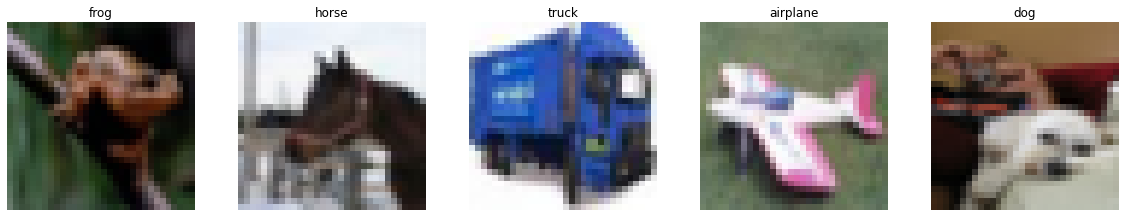

In [6]:
plt.figure(figsize=(20,20))
for i, (image,label) in enumerate(train_ds.take(5)):
    ax= plt.subplot(5, 5, i+1)
    plt.imshow(image)
    plt.title(CLASS_NAMES[label.numpy()[0]])
    plt.axis('off')

The primary preprocessing transformation that will be imposed on the data presented to the network are:
* Normalizing and standardizing the images
* Resizing of the images from 32x32 to 227x227. The AlexNet network inputs expects a 227x227

In [7]:
def process_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    
    # Resize images from 32x32 to 227x227
    image = tf.image.resize(image, (227, 227))
    return image, label

# 4. Data/Input Pipeline

In [8]:
train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
validation_ds_size = tf.data.experimental.cardinality(validation_ds).numpy()
print('Training data sizse:', train_ds_size)
print('Test data size:', test_ds_size)
print('Validation data size:', validation_ds_size)

Training data sizse: 45000
Test data size: 10000
Validation data size: 5000


For our basic input/data pipeline, we will conduct the primary operations:

1. Preprocessing the data within the dataset
2. Shuffle the dataset
3. Batch data within the dataset

In [9]:
train_ds = (train_ds
                    .map(process_images)
                    .shuffle(buffer_size=train_ds_size)
                    .batch(batch_size=32, drop_remainder=True))

test_ds = (train_ds
                .map(process_images)
                .shuffle(buffer_size=train_ds_size)
                .batch(batch_size=32, drop_remainder=True))

validation_ds = (validation_ds
                .map(process_images)
                .shuffle(buffer_size=train_ds_size)
                .batch(batch_size=32, drop_remainder=True))

# 5. Model Implementation

In [10]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227, 227, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
  
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(227, 227, 3)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(227, 227, 3)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(227, 227, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
    ])

# 6. Tensorboard

In [11]:
root_logdir = os.path.join(os.curdir, "logs\\fit\\")

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
                           
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

# 7. Training and Results

In [12]:
model.compile(loss="sparse_categorical_crossentropy", optimizer= tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 384)       8

C:\Users\mmuca\anaconda3\envs\tf2.4\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [13]:
model.fit(train_ds,
          epochs=50,
          validation_data= validation_ds,
          validation_freq=1,
          callbacks=[tensorboard_cb])

Epoch 1/50
1406/1406 [==============================] - 321s 152ms/step - loss: 2.0384 - accuracy: 0.3269 - val_loss: 1.4239 - val_accuracy: 0.4992
Epoch 2/50
1406/1406 [==============================] - 295s 149ms/step - loss: 1.5280 - accuracy: 0.4575 - val_loss: 1.2593 - val_accuracy: 0.5543
Epoch 3/50
1406/1406 [==============================] - 268s 140ms/step - loss: 1.3392 - accuracy: 0.5241 - val_loss: 1.1028 - val_accuracy: 0.6072
Epoch 4/50
1406/1406 [==============================] - 276s 142ms/step - loss: 1.2115 - accuracy: 0.5717 - val_loss: 1.0590 - val_accuracy: 0.6284
Epoch 5/50
1406/1406 [==============================] - 268s 135ms/step - loss: 1.1152 - accuracy: 0.6054 - val_loss: 0.9661 - val_accuracy: 0.6621
Epoch 6/50
1406/1406 [==============================] - 263s 138ms/step - loss: 1.0436 - accuracy: 0.6308 - val_loss: 0.9481 - val_accuracy: 0.6659
Epoch 7/50
1406/1406 [==============================] - 282s 145ms/step - loss: 0.9736 - accuracy: 0.6581 - val_

# 8.Evaluation

In [17]:
model.evaluate(test_ds)

ValueError: in user code:

    C:\Users\mmuca\anaconda3\envs\tf2.4\lib\site-packages\keras\engine\training.py:1330 test_function  *
        return step_function(self, iterator)
    C:\Users\mmuca\anaconda3\envs\tf2.4\lib\site-packages\keras\engine\training.py:1320 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\mmuca\anaconda3\envs\tf2.4\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\mmuca\anaconda3\envs\tf2.4\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\mmuca\anaconda3\envs\tf2.4\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\mmuca\anaconda3\envs\tf2.4\lib\site-packages\keras\engine\training.py:1313 run_step  **
        outputs = model.test_step(data)
    C:\Users\mmuca\anaconda3\envs\tf2.4\lib\site-packages\keras\engine\training.py:1267 test_step
        y_pred = self(x, training=False)
    C:\Users\mmuca\anaconda3\envs\tf2.4\lib\site-packages\keras\engine\base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\mmuca\anaconda3\envs\tf2.4\lib\site-packages\keras\engine\sequential.py:369 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    C:\Users\mmuca\anaconda3\envs\tf2.4\lib\site-packages\keras\engine\functional.py:414 call
        return self._run_internal_graph(
    C:\Users\mmuca\anaconda3\envs\tf2.4\lib\site-packages\keras\engine\functional.py:550 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\mmuca\anaconda3\envs\tf2.4\lib\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\mmuca\anaconda3\envs\tf2.4\lib\site-packages\keras\engine\input_spec.py:214 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer batch_normalization is incompatible with the layer: expected ndim=4, found ndim=5. Full shape received: (32, 32, 55, 55, 96)
